In [1]:
'''
12/08/2023: most uptodate version. Still work in progress.
This script analyzes the results of a set of experiments conducted on different repositories.
It reads the experiment results from various directories and generates a master ledger containing the results.

The script performs the following steps:
1. Imports necessary libraries and modules.
2. Defines the paths to the result repositories.
3. Initializes variables and data structures.
4. Checks if a master ledger file exists. If it does, it loads the existing ledger. Otherwise, it creates a new one.
5. Iterates over each repository, fold, tune, model, and iteration to read the experiment results.
6. Processes the experiment results and updates the master ledger.
7. Saves the master ledger to a pickle file.
8. Defines a function to process each ledger entry in parallel.
9. Executes the processing function using a process pool executor.
10. Collects the results from the processing function.
11. Calculates the execution time and logs the results.
12. Concatenates the ledger results into a single dataframe.
13. Saves the master ledger dataframe to a pickle file.
'''
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import multiprocessing as mp
from multiprocessing import Pool
import time
import logging
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
logging.basicConfig(filename='logs/analyze_all_case_results.log',filemode='w', level=logging.INFO)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

all_results_repos = {'name': 'Path'}

all_results_repos['anxietyE2E/results_archive'] = 'D:/Users/alkurdi/anxietyE2E/results_archive'
all_results_repos['anxietyE2E/results'] = 'D:/Users/alkurdi/anxietyE2E/results'
all_results_repos['anxietyE2E/results_reduced'] = 'D:/Users/alkurdi/anxietyE2E/results_reduced'

all_results_repos['wsl2 may2023'] = 'D:/Users/alkurdi/from_wsl2_created_may_23/wsl2_e2e/results'

all_results_repos['delta old e2e_snr_0.5'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e/results_snr_0.5'
all_results_repos['delta old e2e_copy_snr_0.1'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e_copy/results_snr_0.1'
all_results_repos['delta old e2e_copy_snr_0.2'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e_copy/results_snr_0.2'
all_results_repos['delta old e2e_copy_snr_0.5'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e_copy/results_snr_0.5'
all_results_repos['delta old e2e_copy2_snr_0.01'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e_copy2/results_snr_0.01'
all_results_repos['delta old e2e_copy2_snr_0.1'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e_copy2/results_snr_0.1'
all_results_repos['delta old e2e_copy2_snr_0.2'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e_copy2/results_snr_0.2'
all_results_repos['delta old e2e_copy2_snr_0.5'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e_copy2/results_snr_0.5'
all_results_repos['delta old e2e_snr_0.2_snr_0.2'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e_snr_0.2/results_snr_0.2'
all_results_repos['delta old e2e_snr_0.2_snr_0.5'] = 'D:/Users/alkurdi/delta_old_results/e2e/e2e_snr_0.2/results_snr_0.5'

#all_results_repos['bbyn katerina snr_0.5'] = 'D:/Users/alkurdi/delta_old_results/e2e_bbyn/katerina/results_snr_0.5'
#all_results_repos['bbyn katerina snr_0.5_save'] = 'D:/Users/alkurdi/delta_old_results/e2e_bbyn/katerina/results_snr_0.5_save'

all_results_repos['new_delta_results/results_reduced'] = 'D:/Users/alkurdi/new_delta_results/results_reduced'
#all_results_repos['new_delta_results/results_reduced_before_completion'] = 'D:/Users/alkurdi/new_delta_results/results_reduced_before_completion'
all_results_repos['new_delta_results/binary_results'] = 'D:/Users/alkurdi/new_delta_results/binary_results_home'
#all_results_repos['new_delta_results/results_baseline_3class'] = 'D:/Users/alkurdi/new_delta_results/results_baseline_3class_home' #for some reason this doesn't look like it's fully completed wih the DONE folder missing

#all_results_repos['new_delta_results/results_baseline_3class'] = 'D:/Users/alkurdi/anxietyE2E/results_baseline_3class' # for now i will repeat the experiment and will use this


all_results_repos['new_delta gn_0.4'] = 'D:/Users/alkurdi/new_delta_results/results_n_5_snr_0.4'
all_results_repos['new_delta gn_0.15'] = 'D:/Users/alkurdi/new_delta_results/results_n_5_snr_0.15'
all_results_repos['new_delta gn_0.1'] = 'D:/Users/alkurdi/new_delta_results/results_n_5_snr_0.1'
all_results_repos['new_delta gn_0.01'] = 'D:/Users/alkurdi/new_delta_results/results_n_5_snr_0.01'

all_results_repos['new_delta baseline'] = 'D:/Users/alkurdi/new_delta_results/results'


e2e_model_list = ['fcnM',  'resnetM', 'inceptionM',
                  'cnnLstmM', 'cnnM', 'mcdcnnM', 
             'mlpLstmM', 'mlpM', 
              'encoderM', ]

In [2]:
pd.set_option('display.max_rows', 500)

done_list = {}
master_ledger = {'name':{'df_best_model':{}, 'df_metrics':{}, 'history':{}, 'result':{}, 'aggregated_classification_reports':{}, 'done':{}}}
counter=0
force_update = False # ran once 12/10/2023
if os.path.isfile('D:/Users/alkurdi/master_ledger.pkl') and force_update != True:
    with open('D:/Users/alkurdi/master_ledger.pkl', 'rb') as handle:
        master_ledger = pickle.load(handle)
    print('loaded master ledger')
else:
    for name, Path in all_results_repos.items():
        print('-'*20+'\n'+'-'*20+'\n'+'processing: '+name)
        if name != 'name':        
            fold_gen = (i for i in os.listdir(Path) if 'WESAD' in i)
            for fold in fold_gen:
                tune_gen = (i for i in os.listdir(Path+'/'+fold) if 'tune' in i)
                for tune in tune_gen:
                    model_gen = (i for i in os.listdir(Path+'/'+fold+'/'+str(tune)))
                    for model in model_gen:
                        it_gen = ( i for i in os.listdir(Path+'/'+fold+'/'+str(tune)+'/'+model) if 'it' in i)
                        for it in it_gen:
                            counter+=1
                            inst_name = str(name+'_'+fold+'_'+tune+'_'+model+'_'+it)
                            master_ledger[inst_name] = {}
                            try: 
                                in_path = Path+'/'+fold+'/'+str(tune)+'/'+model+'/'+str(it)
                                df_best_model = pd.read_csv(in_path+'/df_best_model.csv')
                                df_metrics = pd.read_csv(in_path+'/df_metrics.csv')
                                history = pd.read_csv(in_path+'/history.csv')
                                aggregated_classification_reports = {}
                                #aggregated_confusion_matrices = {}
                                metrics = ["precision", "recall", "f1-score", "support"]
                                with open(in_path+'/predictions.txt') as f:
                                    y_true = [int(x) for x in f.readline().split()]
                                    y_pred = [int(x) for x in f.readline().split()]
                                if len(aggregated_classification_reports) == 0:
                                    for clas in set(y_true):
                                        aggregated_classification_reports[clas] = {"f1-score": [], "precision": [], "recall": [],
                                                                                    "support": []}
                                report = classification_report(y_true, y_pred, output_dict=True)
                                cm = confusion_matrix(y_true, y_pred)
                                for clas in aggregated_classification_reports:
                                    for metric in metrics:
                                        aggregated_classification_reports[clas][metric].append(report[str(clas)][metric]) # type: ignore
                                aggregated_confusion_matrices = cm
                                result = []
                                for clas in aggregated_classification_reports:
                                    row = ['WESAD', clas]
                                    for metric in metrics:
                                        metric_values = aggregated_classification_reports[clas][metric]
                                        row.append(np.mean(metric_values))
                                        row.append(np.std(metric_values))
                                    result.append(row[:-1])  # Remove support std
                                is_done = os.path.isdir(in_path+'/DONE')
                                if is_done:
                                    done_list[in_path] = is_done            
                                master_ledger[inst_name]['df_best_model'] = df_best_model # type: ignore
                                master_ledger[inst_name]['df_metrics'] = df_metrics # type: ignore
                                master_ledger[inst_name]['history'] = history # type: ignore
                                master_ledger[inst_name]['result'] = result # type: ignore
                                master_ledger[inst_name]['aggregated_classification_reports'] = aggregated_classification_reports
                                master_ledger[inst_name]['aggregated_confusion_matrices'] = aggregated_confusion_matrices # type: ignore
                                master_ledger[inst_name]['is_done'] = is_done           # type: ignore
                            except Exception as e:
                                master_ledger[inst_name]['df_best_model'] = None # type: ignore
                                master_ledger[inst_name]['df_metrics'] = None # type: ignore
                                master_ledger[inst_name]['history'] = None # type: ignore
                                master_ledger[inst_name]['result'] = None # type: ignore
                                master_ledger[inst_name]['aggregated_classification_reports'] = None # type: ignore
                                master_ledger[inst_name]['aggregated_confusion_matrices'] = None # type: ignore
                                master_ledger[inst_name]['is_done'] = None # type: ignore
                                if 'stres' not in model: 
                                    print('during '+name+'_'+fold+'_'+tune+'_'+model+'_'+it+' an error occured: ')
                                    print(e)
    print('done. Processed '+str(counter)+' instances. Thank you for your cooperation')                                               
    with open('D:/Users/alkurdi/master_ledger.pkl', 'wb') as handle:
        pickle.dump(master_ledger, handle, protocol=pickle.HIGHEST_PROTOCOL)

loaded master ledger


# to add missing entries from all_results_repos

In [3]:
#all_results_repos['new_delta baseline'] = '/mnt/d/Users/alkurdi/new_delta_results/results'
#name = 'new_delta baseline'
#Path = all_results_repos[name]
def perform_missing(name, Path):
    fold_gen = (i for i in os.listdir(Path) if 'WESAD' in i)
    for fold in fold_gen:
        tune_gen = (i for i in os.listdir(Path+'/'+fold) if 'tune' in i)
        for tune in tune_gen:
            model_gen = (i for i in os.listdir(Path+'/'+fold+'/'+str(tune)))
            for model in model_gen:
                it_gen = ( i for i in os.listdir(Path+'/'+fold+'/'+str(tune)+'/'+model) if 'it' in i)
                for it in it_gen:
                    inst_name = str(name+'_'+fold+'_'+tune+'_'+model+'_'+it)
                    master_ledger[inst_name] = {}
                    try: 
                        in_path = Path+'/'+fold+'/'+str(tune)+'/'+model+'/'+str(it)
                        df_best_model = pd.read_csv(in_path+'/df_best_model.csv')
                        df_metrics = pd.read_csv(in_path+'/df_metrics.csv')
                        history = pd.read_csv(in_path+'/history.csv')
                        aggregated_classification_reports = {}
                        #aggregated_confusion_matrices = {}
                        metrics = ["precision", "recall", "f1-score", "support"]
                        with open(in_path+'/predictions.txt') as f:
                            y_true = [int(x) for x in f.readline().split()]
                            y_pred = [int(x) for x in f.readline().split()]
                        if len(aggregated_classification_reports) == 0:
                            for clas in set(y_true):
                                aggregated_classification_reports[clas] = {"f1-score": [], "precision": [], "recall": [],
                                                                            "support": []}
                        report = classification_report(y_true, y_pred, output_dict=True)
                        cm = confusion_matrix(y_true, y_pred)
                        for clas in aggregated_classification_reports:
                            for metric in metrics:
                                aggregated_classification_reports[clas][metric].append(report[str(clas)][metric]) # type: ignore
                        aggregated_confusion_matrices = cm
                        result = []
                        for clas in aggregated_classification_reports:
                            row = ['WESAD', clas]
                            for metric in metrics:
                                metric_values = aggregated_classification_reports[clas][metric]
                                row.append(np.mean(metric_values))
                                row.append(np.std(metric_values))
                            result.append(row[:-1])  # Remove support std
                        is_done = os.path.isdir(in_path+'/DONE')
                        if is_done:
                            done_list[in_path] = is_done            
                        master_ledger[inst_name]['df_best_model'] = df_best_model # type: ignore
                        master_ledger[inst_name]['df_metrics'] = df_metrics # type: ignore
                        master_ledger[inst_name]['history'] = history # type: ignore
                        master_ledger[inst_name]['result'] = result # type: ignore
                        master_ledger[inst_name]['aggregated_classification_reports'] = aggregated_classification_reports
                        master_ledger[inst_name]['aggregated_confusion_matrices'] = aggregated_confusion_matrices # type: ignore
                        master_ledger[inst_name]['is_done'] = is_done           # type: ignore
                    except Exception as e:
                        master_ledger[inst_name]['df_best_model'] = None # type: ignore
                        master_ledger[inst_name]['df_metrics'] = None # type: ignore
                        master_ledger[inst_name]['history'] = None # type: ignore
                        master_ledger[inst_name]['result'] = None # type: ignore
                        master_ledger[inst_name]['aggregated_classification_reports'] = None # type: ignore
                        master_ledger[inst_name]['aggregated_confusion_matrices'] = None # type: ignore
                        master_ledger[inst_name]['is_done'] = None # type: ignore
                        print('during '+name+'_'+fold+'_'+tune+'_'+model+'_'+it+' an error occured: ')
                        print(e)
    return master_ledger

#missing_m_ledger = perform_missing(name, Path)


#keys_to_delete = []
#for key in master_ledger:
#    if "baseline" in key:
#        keys_to_delete.append(key)
#print('keys to delete',keys_to_delete)
#for key in keys_to_delete:
#    del master_ledger[key]

In [4]:
incomplete_entries = []
not_done_entries = []
for key, value in master_ledger.items():
    if value['df_best_model'] is None:
        #print('key: '+key)#+' is missing df_best_model')
        #print(f'name: {key.split("_WESAD")[0]}')
        pass
    for needed_key in all_results_repos.items():
        if needed_key[0] in key and value['df_best_model'] is None:
            #print('key: '+key+' is missing df_best_model')
            if 'stresnetM' not in needed_key: not_done_entries.append(key)
        incomplete_entries.append(key)
nonstresnet_incomp = []
for entry in incomplete_entries:
    if 'stresnetM' not in entry:
        #print(entry)
        nonstresnet_incomp.append(entry)

In [5]:
#print(*set(nonstresnet_incomp) , sep = "\n")
important_imcomplete_entries = []
for item in not_done_entries:
    if 'new' in item and 'stres' not in item:
        important_imcomplete_entries.append(item)
print(*set(important_imcomplete_entries) , sep = "\n")
#print('\n',*set(not_done_entries), sep = "\n")
#incomplete_entries.append(key.split("_WESAD")[0])
len(important_imcomplete_entries)

new_delta_results/binary_results_WESAD_5fold_04_tune_05_inceptionM_it_00
new_delta_results/binary_results_WESAD_5fold_01_tune_05_resnetM_it_02


2

In [6]:
#create a multiprocess function to run the following code in parallel
from doctest import master
import traceback

def process_each_ledger(key):
    ledger_df = pd.DataFrame()
    try:
        if key != 'name':  
            case_df = pd.DataFrame()
            if master_ledger[key]['aggregated_classification_reports'] is None:
                case_df['f1 binary'] = [0]
                pass
            else: 
                case_df['f1 binary']= master_ledger[key]['aggregated_classification_reports'][1]['f1-score'] # 2= stress for wesad, but for E2E, it's shifted to one via utilz.transform_labels
                pass
            case_df['is_done'] = master_ledger[key]['is_done']
            case_df['it'] = key.split('_')[-1]
            case_df['model'] = key.split('_')[-3]
            case_df['tune'] = key.split('_')[-4]
            case_df['fold'] = key.split('_')[-6]
            case_df['name'] = key
            
            cm = master_ledger[key]['aggregated_confusion_matrices']
            if cm is None:
                case_df['TP'] = 0
                case_df['FP'] = 0
                case_df['FN'] = 0
                case_df['TN'] = 0
                case_df['f1 binary'] = 0
                case_df['TPR'] = 0
                case_df['TNR'] = 0 
                case_df['PPV'] = 0
                case_df['NPV'] = 0
                case_df['FPR'] = 0
                case_df['FNR'] = 0
                case_df['FDR'] = 0
                case_df['specificity'] = 0
                ledger_df = pd.concat([ledger_df, master_ledger[key]['df_best_model'],
                                   master_ledger[key]['df_metrics'], case_df], axis = 1) # type: ignore
                ledger_df['stats calc status'] = 'error - cm none'
                
            elif cm.shape == (3,3):
                a = cm.ravel()[0] + cm.ravel()[2] + cm.ravel()[6] + cm.ravel()[8]
                b = cm.ravel()[1] + cm.ravel()[7]
                c = cm.ravel()[3] + cm.ravel()[5]
                d = cm.ravel()[4]
                tp = d
                tn = a
                fp = b
                fn = c
                perc = [tp/ (tp+fp) if (tp + fp) != 0 else 0]
                recall = [tp / (tp + fn) if (tp + fn) != 0 else 0]
                f1_bin = 2 * (perc[0] * recall[0]) / (perc[0] + recall[0]) if (perc[0] + recall[0]) != 0 else 0

                case_df['TP'] = cm.ravel()[4] # type: ignore
                case_df['FP'] = cm.ravel()[1:8:6].sum() # type: ignore
                case_df['FN'] = cm.ravel()[3:6:2].sum() # type: ignore
                case_df['TN'] = cm.sum() - (case_df['FP'] + case_df['FN'] + case_df['TP']) # type: ignore
                case_df['f1 binary'] = f1_bin

                # Sensitivity, hit rate, recall, or true positive rate
                case_df['TPR'] = case_df['TP']/(case_df['TP']+case_df['FN'])
                # Specificity or true negative rate
                case_df['TNR'] = case_df['TN']/(case_df['TN']+case_df['FP']) 
                # Precision or positive predictive value
                case_df['PPV'] = case_df['TP']/(case_df['TP']+case_df['FP'])
                # Negative predictive value
                case_df['NPV'] = case_df['TN']/(case_df['TN']+case_df['FN'])
                # Fall out or false positive rate
                case_df['FPR'] = case_df['FP']/(case_df['FP']+case_df['TN'])
                # False negative rate
                case_df['FNR'] = case_df['FN']/(case_df['TP']+case_df['FN'])
                # False discovery rate
                case_df['FDR'] = case_df['FP']/(case_df['TP']+case_df['FP'])
                #specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
                case_df['specificity'] = [((tn / (tn + fp)) if (tn + fp) != 0 else 0)]
                ledger_df = pd.concat([ledger_df, master_ledger[key]['df_best_model'],
                                   master_ledger[key]['df_metrics'], case_df], axis = 1) # type: ignore
                ledger_df['stats calc status'] = 'success'
            elif cm.shape == (2,2):
                a = cm.ravel()[0]
                b = cm.ravel()[1]
                c = cm.ravel()[2]
                d = cm.ravel()[3]
                tp = d
                tn = a
                fp = b
                fn = c
                perc = [tp/ (tp+fp) if (tp + fp) != 0 else 0]
                recall = [tp / (tp + fn) if (tp + fn) != 0 else 0]
                f1_bin = 2 * (perc[0] * recall[0]) / (perc[0] + recall[0]) if (perc[0] + recall[0]) != 0 else 0

                case_df['TP'] = tp
                case_df['FP'] = fp
                case_df['FN'] = fn
                case_df['TN'] = tn
                case_df['f1 binary'] = f1_bin

                # Sensitivity, hit rate, recall, or true positive rate
                case_df['TPR'] = case_df['TP']/(case_df['TP']+case_df['FN'])
                # Specificity or true negative rate
                case_df['TNR'] = case_df['TN']/(case_df['TN']+case_df['FP']) 
                # Precision or positive predictive value
                case_df['PPV'] = case_df['TP']/(case_df['TP']+case_df['FP'])
                # Negative predictive value
                case_df['NPV'] = case_df['TN']/(case_df['TN']+case_df['FN'])
                # Fall out or false positive rate
                case_df['FPR'] = case_df['FP']/(case_df['FP']+case_df['TN'])
                # False negative rate
                case_df['FNR'] = case_df['FN']/(case_df['TP']+case_df['FN'])
                # False discovery rate
                case_df['FDR'] = case_df['FP']/(case_df['TP']+case_df['FP'])
                #specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
                case_df['specificity'] = [((tn / (tn + fp)) if (tn + fp) != 0 else 0)]
            
                ledger_df = pd.concat([ledger_df, master_ledger[key]['df_best_model'],
                                   master_ledger[key]['df_metrics'], case_df], axis = 1) # type: ignore
                ledger_df['stats calc status'] = 'success'
            else:
                case_df['TP'] = 0
                case_df['FP'] = 0
                case_df['FN'] = 0
                case_df['TN'] = 0
                case_df['f1 binary'] = 0
                
                case_df['TPR'] = 0
                case_df['TNR'] = 0 
                case_df['PPV'] = 0
                case_df['NPV'] = 0
                case_df['FPR'] = 0
                
                case_df['FNR'] = 0
                case_df['FDR'] = 0
                case_df['specificity'] = 0
                
                ledger_df = pd.concat([ledger_df, master_ledger[key]['df_best_model'],
                                   master_ledger[key]['df_metrics'], case_df], axis = 1)
                ledger_df['stats calc status'] = f'error - {type(cm)} not supported'
    except Exception as e:
        # Log the exception
        logging.error(f"Error processing ledger {i}: {e}")
        logging.error(f'cm \n{cm}')
        logging.error(f'key {key}')
        # Also log the full exception traceback
        logging.error(traceback.format_exc())
        
    return ledger_df

In [7]:
import concurrent.futures
import logging

logging.basicConfig(filename='logs/analyze_all_case_results.log',filemode='w', level=logging.INFO)

if __name__ == '__main__':
    ledger_results = []
    force_update = False # ran on 12/10/2023
    if os.path.isfile('D:/Users/alkurdi/master_ledger_df.pkl') and force_update != True:
        with open('D:/Users/alkurdi/master_ledger_df.pkl', 'rb') as handle:
            master_ledger_df = pickle.load(handle)
        print('loaded ledger_results')
    else:
        print('file not found or force_update is True')
        start_time = time.time()
        keychain = list(master_ledger.keys())
        master_ledger_df = pd.DataFrame()
        with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
                futures = [executor.submit(process_each_ledger, i) for i in keychain]
                done, not_done = concurrent.futures.wait(futures, return_when='ALL_COMPLETED')
                logging.debug(f'done assigning futures, now waiting for them to finish')
                for future in done:
                    ledger_results = future.result()
                    master_ledger_df = pd.concat([master_ledger_df, ledger_results], axis = 0)
        master_ledger_df.reset_index(drop=True,inplace=True)
        imax =len(master_ledger)
        logging.info(f'finished {imax} iterations in {round(time.time()-start_time,2)} seconds')
        logging.info(f'an average of {(time.time()-start_time)/imax} seconds per iteration')

        with open('D:/Users/alkurdi/master_ledger_df.pkl', 'wb') as f:
                    pickle.dump(master_ledger_df, f)
print(f'we have about {-len(master_ledger_df)+ len(master_ledger)} fucked up cases')
n_not_done = (master_ledger_df['is_done']==False).sum()
n_done = (master_ledger_df['is_done']==True).sum()
n_neigther = ((master_ledger_df['is_done']!= True ) & (master_ledger_df['is_done']!= False) ).sum()
print(f' not done {n_not_done}. done {n_done}. else {n_neigther}. tot = {n_done+n_neigther+n_not_done}')
master_ledger_df[master_ledger_df['is_done']==True].round(3)
columns_yuck = ['best_model_train_loss', 'best_model_val_loss', 'best_model_train_acc', 'best_model_val_acc',
                'best_model_learning_rate', 'best_model_nb_epoch', 'precision', 'accuracy',
                'recall', 'duration', 'auc', 'is_done', 'TP' ,'FP', 'FN', 'TN',
                'TPR', 'TNR', 'PPV', 'NPV', 'FPR', 'FNR', 'FDR', 'stats calc status']
nice_dones = master_ledger_df[master_ledger_df['is_done']==True].drop(columns=columns_yuck).copy()


loaded ledger_results
we have about 1 fucked up cases
 not done 5121. done 14594. else 53. tot = 19768


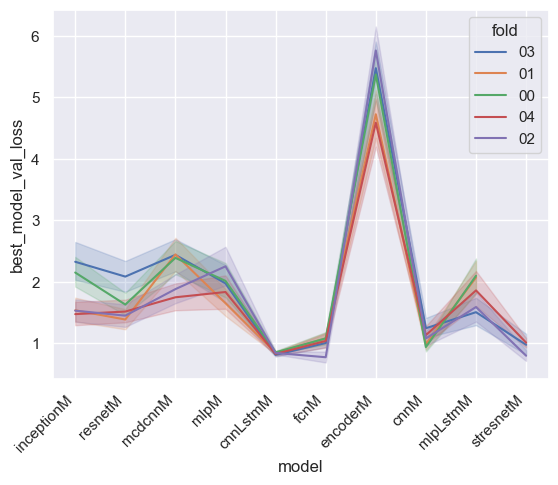

In [9]:
sns.set()
sns.plotting_context("talk")

plt.figure()
#master_ledger_df['best_model_val_loss'].plot(kind='kde')
#master_ledger_df['best_model_train_loss'].plot(kind='kde')

#sns.set_palette("Set2")

a = sns.lineplot(data=master_ledger_df,y = 'best_model_val_loss', x = 'model', hue = 'fold')
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right');plt.show()



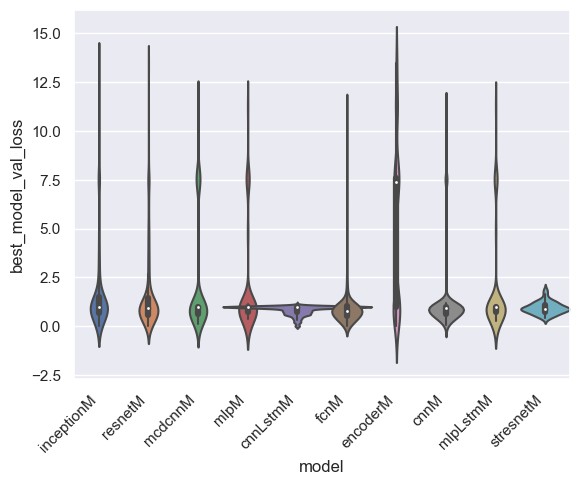

In [10]:
sns.set()
plt.figure()
a = sns.violinplot(data=master_ledger_df,
               y = 'best_model_val_loss',
               x = 'model',
               #hue = 'fold',
               width = 3, 
               )
a.set_yscale('linear')
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right');

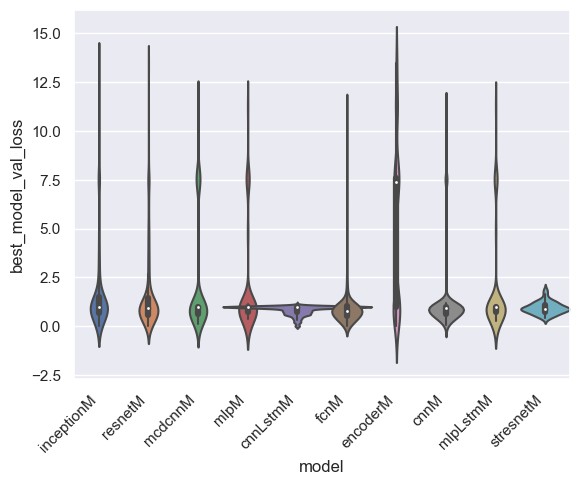

In [11]:
plt.figure()
a = sns.violinplot(data=master_ledger_df,
               y = 'best_model_val_loss',
               x = 'model',
               #hue = 'fold',
               width = 3,      
               )
a.set_yscale('linear')
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right');

#sns.set_theme(style="whitegrid")
#sns.set_palette("Set2")
sns.set_context("paper")

In [58]:
master_ledger_df[['best_model_val_loss','best_model_train_acc']]

,best_model_val_loss,best_model_train_acc
0,0.995932,0.541916
1,7.535160,0.878743
2,0.292011,0.951662
3,0.995554,0.511976
4,0.625376,0.696375
...,...,...
19763,0.979402,0.578313
19764,0.703875,0.808735
19765,0.690741,1.000000
19766,0.993958,0.545181


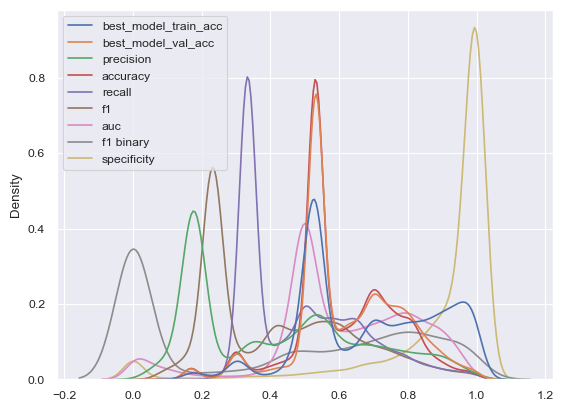

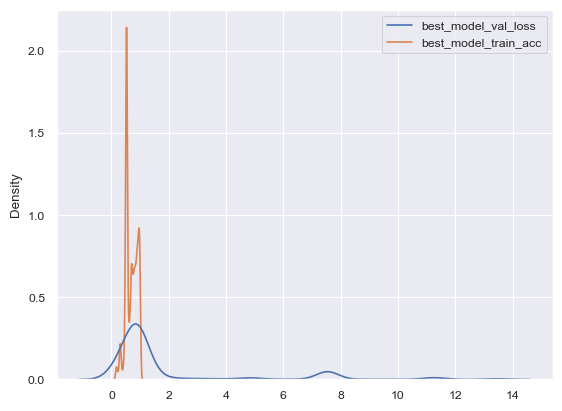

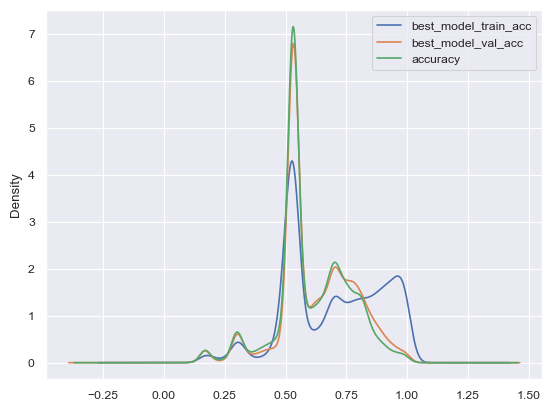

In [60]:
sns.kdeplot(data=master_ledger_df.drop(columns=['is_done', 'it', 'model', 'tune', 'fold', 'name', 'TP', 'FP', 'FN','duration', 
        'TN', 'TPR', 'TNR', 'PPV', 'NPV', 'FPR', 'FNR', 'FDR',
        # 'best_model_train_acc',
        #'best_model_val_acc', 
        'best_model_learning_rate', 'best_model_nb_epoch','best_model_train_loss', 'best_model_val_loss',
        'stats calc status']),
               #x = 'best_model_val_acc',
               #hue = 'fold',
               #width = 3,      
               )

plt.figure()
sns.kdeplot(data=master_ledger_df[['best_model_val_acc','best_model_train_acc']],
               #x = 'best_model_val_acc',
               #hue = 'fold',
               #width = 3,      
               )
plt.show()

plt.figure()
sns.kdeplot(data=master_ledger_df[['best_model_train_acc','best_model_val_acc', 'accuracy']],
               #x = 'best_model_val_acc',
               #hue = 'fold',
               #width = 3,      
               )
master_ledger_df['best_model_train_acc'].plot(kind='kde')
master_ledger_df['best_model_val_acc'].plot(kind='kde') #best
master_ledger_df['accuracy'].plot(kind='kde')
plt.legend()

plt.show()



# All needed result calculations

In [13]:
reduceds = nice_dones[nice_dones.isin([i for i in nice_dones['name'].values if '_results/results_reduced' in i]).values]

reduceds = nice_dones[nice_dones.isin([i for i in nice_dones['name'].values if '_results/results_reduced' in i]).values]

snr15 = nice_dones[nice_dones['name'].str.contains("0.15_")]
snr15['snr'] = 0.15
snr40 = nice_dones[nice_dones['name'].str.contains("0.4_")]
snr40['snr'] = 0.4
snr10 = nice_dones[nice_dones['name'].str.contains("0.1_")]
snr10['snr'] = 0.1
snr01 = nice_dones[nice_dones['name'].str.contains("0.01_")]
snr01['snr'] = 0.01
reduced_by_models = nice_dones[nice_dones.isin([i for i in nice_dones['name'].values if 'reduced' in i]).values].groupby(['model'])
e2e_gn = pd.concat([snr01, snr10, snr15, snr40])

best_performing = reduceds.groupby(['model', 'fold'])['f1 binary'].max().reset_index()
best_performing.groupby('model').mean()
best_performing_wesad = best_performing.groupby('model').mean().loc[best_performing.groupby('model').mean().idxmax()]

baseline = nice_dones[nice_dones.isin([i for i in nice_dones['name'].values if 'new_delta baseline' in i]).values]

# plotting across folds

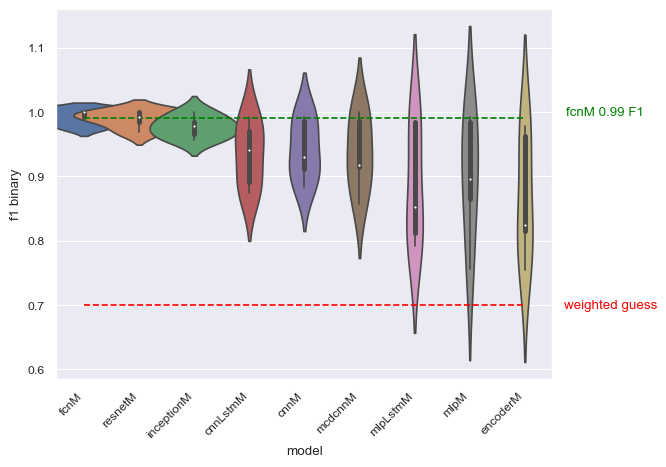

In [21]:
# get best performing f1 binary result per model per fold
sns.set_context("paper")
a = sns.violinplot(data=best_performing, x='model', y='f1 binary',
                errorbar='pi',
                order = e2e_model_list,
                width=3.5,
                )
#plt.show()
a.set_xlim([-.5,8.5])
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right');

a.text(x=09.55, y=0.7, s='weighted guess', color='red', va='center', ha='center')
a.hlines(y=0.7, xmin=0, xmax=8, linestyles='dashed',color='red')

a.text(x=9.45, y=1,
       s=f'{best_performing_wesad.index[0]} {round(best_performing_wesad.values[0][0],2)} F1',
       va='center', ha='center',
       color='green')
a.hlines(y=round(best_performing_wesad.values[0][0],2),
         xmin=0, xmax=8, 
         linestyles='dashed', color='green')
plt.show()

## Effect of reducing classes, which causes overfitting and weak generalization.  

In [23]:
model_fold_grouped = reduceds.groupby(['model','fold'])
reduceds_sorted = reduceds.sort_values('model' ).reset_index(drop=True)
reduceds_sorted['type'] = 'reduced modalities'
# original['type'] = 'original'
# combined = pd.concat([reduceds_sorted, original])

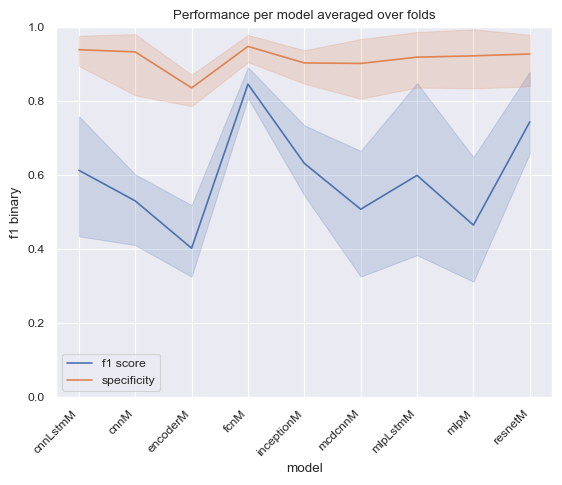

In [24]:
a = sns.lineplot(data=model_fold_grouped.mean().sort_values('model'),
                 x='model',
                 y='f1 binary',
                 errorbar='pi',
                 #hue= 'type'
                 sort= True,
                 label = 'f1 score')

a.legend(['f1','specificity'], loc='lower right')

a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right')
a.set_ylim(0,1)
a.set_title('Performance per model averaged over folds')

a = sns.lineplot(data=model_fold_grouped.mean().sort_values('model'),
                    x='model',
                    y='specificity',
                    errorbar='pi',
                    #hue= 'type',
                    sort= True,
                    label = 'specificity')

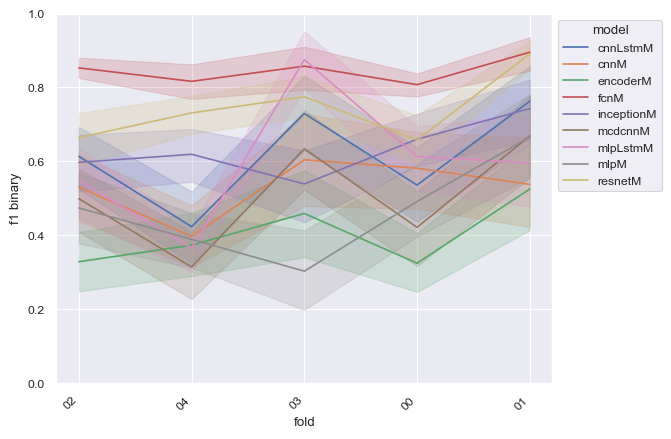

In [17]:

a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right',
                  #hue= 'fold',
                  )
a.set_ylim(0,1)

plt.figure()
a = sns.lineplot(data=reduceds_sorted, x='fold',y='f1 binary',
                 sort= True,
                 hue= 'model',
                 )
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right',
                  #hue= 'fold',
                  )
a.set_ylim(0,1)
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
#this should compare reduced with 3class original modalities. 

## 3 class with Binary models

This should highlight the effects of reducing classes, which causes overfitting and weak generalization.  

In [ ]:
#triclass = nice_dones[nice_dones.isin([i for i in nice_dones['name'].values if '3class' in i]).values]
################################
### Tris #### should be changed to be defined from dones instead ofmaster_ledger_df
################################

tris= (master_ledger_df[master_ledger_df.isin([i for i in master_ledger_df['name'].values if 'baseline' in i]).values])
binary= (master_ledger_df[master_ledger_df.isin([i for i in master_ledger_df['name'].values if 'binary' in i]).values])
tris['type'] = 'baseline'
binary['type'] = 'binary'
tris = tris[tris['model']!='stresnetM']
binary = binary[binary['model']!='stresnetM']
bin_tris = pd.concat([tris, binary], axis=0)

a.set_title('F1 Scores for GN-WESAD E2E into binary vs 3class models')
b = sns.violinplot(x="type", y="f1 binary", data=bin_tris,
                    #hue=hue,
                    #linewidth = 1.,
                    #width=2,
                    )
b.set_xticklabels(b.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.figure(figsize=(12,10))

a = sns.violinplot(x="model", y="f1 binary", data=bin_tris,
                    hue='type',
                    linewidth = 2.5,
                    #width=1.5,
                    split=True,
                    bw_adjust=.5, 
                    #palette="muted",
                    #order = e2e_model_list,
                    #dodge=01.2,# join=False,
                    )
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right')
a.set_title('F1 Scores for GN-WESAD E2E into binary vs 3class models')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

# reduced modality 


In [ ]:
reduceds['type'] = 'reduced modality 4 chest, 7 wrist'
baseline['type'] = 'original wesad 7 chest 7 wrist'
red_bas = pd.concat([reduceds,baseline])

In [ ]:
a.set_title('F1 Scores for GN-WESAD E2E into binary vs 3class models')
b = sns.violinplot(x="type", y="f1 binary", data=red_bas,
                    #hue=hue,
                    #linewidth = 1.,
                    #width=2,
                    )
b.set_xticklabels(b.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.figure(figsize=(12,10))

a = sns.violinplot(x="model", y="f1 binary", data=red_bas,
                    hue='type',
                    linewidth = 2.5,
                    #width=1.5,
                    split=True,
                    bw_adjust=.5, 
                    #palette="muted",
                    #order = e2e_model_list,
                    #dodge=01.2,# join=False,
                    )
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right')
a.set_title('F1 Scores for GN-WESAD E2E into binary vs 3class models')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
red_bas

In [ ]:
plt.figure(figsize=(12,10))

a = sns.violinplot(x="model", y="f1 binary", data=red_bas,
                    hue='tune',
                    linewidth = .5,
                    #width=1.5,
                    #split=True,
                    #bw_adjust=.5, 
                    #palette="muted",
                    #order = e2e_model_list,
                    #dodge=01.2,# join=False,
                    )
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right')
a.set_title('F1 Scores for GN-WESAD E2E into binary vs 3class models')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

## looking 

looking closely at performance of models at different noise functions 

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(4, sharey= True, figsize=(10,20))
plt.subplots_adjust(hspace=0.9)
ax[0].set_title('SNR 0.01')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[1].set_title('SNR 0.1')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[2].set_title('SNR 0.15')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[3].set_title('SNR 0.4')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45, horizontalalignment='right')

d = sns.violinplot(ax = ax[0], x="model", y="f1 binary", data=snr01,
                    #hue=hue,
                    #linewidth = 1.,
                    #width=1.2,
                    order = e2e_model_list,
                    )

a = sns.violinplot(ax = ax[1], x="model", y="f1 binary", data=snr10,
                    #hue=hue,
                    #linewidth = 1.,
                    #width=2.5,
                    order = e2e_model_list,
                    )
#sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))

b = sns.violinplot(ax=ax[2], x="model", y="f1 binary", data=snr15,
                    #hue=hue,
                    #linewidth = 1.,
                    #width=2,
                    order = e2e_model_list,
                    )
#sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
c = sns.violinplot(ax = ax[3],x="model", y="f1 binary", data=snr40,
                    #hue=hue,
                    #linewidth = 1.,
                    #width=2,
                    order = e2e_model_list,
                    )
#fig.suptitle('F1 Scores for GN-WESAD E2E models closerlook')


In [ ]:
sns.set()

fig, ax = plt.subplots(4, sharey= True, figsize=(10,12))
fig.suptitle('F1 Scores for GN-WESAD E2E models SNR closelook')
plt.subplots_adjust(hspace=1.0)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')

ax[0].set_title('SNR 0.01')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')

ax[1].set_title('SNR 0.1')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[2].set_title('SNR 0.15')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, horizontalalignment='right')

ax[3].set_title('SNR 0.4')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45, horizontalalignment='right')
hue = 'tune'

a = sns.violinplot(ax = ax[0],x="snr", y="f1 binary", data=e2e_gn,
                    #hue=hue,
                    #linewidth = 1.2,
                    #width=.4,
                    )


b = sns.violinplot(ax=ax[1], x="model", y="f1 binary", data=e2e_gn,
                   #hue='model',
                    linewidth = 1.2,
                    #width=2,
                    order = e2e_model_list)
c = sns.violinplot(ax=ax[2], x="model", y="f1", data=e2e_gn,
                   #hue='model',
                    linewidth = 1.2,
                    #width=2,
                    order = e2e_model_list)
'''c = sns.violinplot(ax = ax[2],x="model", y="f1 binary", data=snr40,
                    hue=hue,
                    linewidth = 1.2,width=2,)'''
d = sns.violinplot(ax = ax[3],x="model", y="f1 binary", data=snr40,
                    #hue=hue,
                    linewidth = 1.2,
                    #width=2,
                    order = e2e_model_list)


#x.set_title('SNR 0.1')


In [ ]:
sns.pairplot(snr10, hue="tune", height=3.5)


In [ ]:
sns.set_palette("Set2")
sns.set_context("paper")
sns.set(
    font_scale=1.2,
)
sns.set_style("ticks")
plt.figure(figsize=(12, 8))
ax = sns.lineplot(
    x="snr", y="f1 binary", 
    hue="model", data=e2e_gn, marker='*',
    errorbar='sd'
)  # .set_title('GN-WESAD')
ax.set_ylim([0, 1])
ax.legend(loc='upper left')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

sns.set_style("ticks")
plt.figure(figsize=(12, 8))
# To add the 90th percentile shading, you can calculate it manually and use plt.fill_between()
upper = e2e_gn.groupby('snr')['f1 binary'].quantile(1)  # This gets the maximum value if your data is not skewed
lower = e2e_gn.groupby('snr')['f1 binary'].quantile(0.95)  # This is the 90th percentile
# Calculate the midpoint between the upper and lower bands
midpoint = (upper + lower) / 2

# Plot the midpoint line
a = sns.lineplot(x=e2e_gn['snr'].unique(), y=midpoint,
             #hue='model' ,
             #color='black', lw=2
             label='95%-100% percentile')

# Now, shade between the 90th percentile and the maximum value
plt.fill_between(e2e_gn['snr'].unique(), lower, 
                 upper, color='blue', alpha=0.3)

ax = sns.lineplot(
    x="snr", y="f1", hue="model", data=e2e_gn, marker='*'
)  # .set_title('GN-WESAD')
ax.legend(loc='upper left')
ax.set_title('F1 Score vs SNR best performing models')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));



p975 = e2e_gn["f1 binary"].quantile(0.975)
p90 = e2e_gn["f1 binary"].quantile(0.9)
p100 = e2e_gn["f1 binary"].quantile(1)
p95 = e2e_gn["f1 binary"].quantile(0.95)

In [ ]:
# To add the 90th percentile shading, you can calculate it manually and use plt.fill_between()
upper = e2e_gn.groupby('snr')['f1 binary'].quantile(1)  # This gets the maximum value if your data is not skewed
lower = e2e_gn.groupby('snr')['f1 binary'].quantile(0.95)  # This is the 90th percentile
# Calculate the midpoint between the upper and lower bands
midpoint = (upper + lower) / 2

# Plot the midpoint line
a = sns.lineplot(x=e2e_gn['snr'].unique(), y=midpoint,
             #hue='model' ,
             #color='black', lw=2
             label='95%-100% percentile')
a.set_xlabel('snr')
a = sns.lineplot(x='snr', y='f1 binary',
                data=e2e_gn,
                hue='model' ,
                #color='black', lw=2,
                errorbar=None,
                )
plt.title('F1 Score vs SNR')
# Now, shade between the 90th percentile and the maximum value
plt.fill_between(e2e_gn['snr'].unique(), lower, 
                 upper, color='blue', alpha=0.3)
a.set_ylim([0, 1])
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1));


#fig, ax= plt.subplot(339)
'''g = sns.FacetGrid(data=e2e_gn, col='model', col_wrap=3)
g.map(sns.lineplot, 'snr', 'f1 binary',  errorbar='pi')
g.set_titles('{col_name}')
g.set_axis_labels('snr', 'f1 Score')
g.set(ylim=(0, 1))
g.add_legend()'''


#####################
# my facet grid
#####################

def draw_subplot(data, color):
    #display(data.drop(columns=['upper', 'lower']))
    upper = data.groupby('snr')['f1 binary'].quantile(1)
    lower = data.groupby('snr')['f1 binary'].quantile(0.95)
    midpoint = (upper + lower) / 2
    
    
    sns.lineplot(x=data['snr'].unique(), y=midpoint,
             #hue='model' ,
             #color='black', lw=2
             label='95%-100% percentile')
    
    plt.fill_between(data['snr'].unique(), lower, 
                     upper, color='blue', alpha=0.3)                     
    #display(data)
    
    best_performing = data[data['snr']==0.4].groupby(['model', 'fold'])['f1 binary'].max().reset_index()
    #display(best_performing)
    best_performing.groupby('model').mean()
    #display(best_performing.groupby('model').mean())

    #best_performing_wesad = best_performing.groupby('model').mean().loc[best_performing.groupby('model').mean().idxmax()]
    #best_performing_wesad = best_performing.groupby('model').mean().loc[best_performing.groupby('model').mean().idxmax()]
    #data.groupby('model').mean().loc[data.groupby('model').mean().idxmax()]
    #print(best_performing.groupby('model').mean().values[0][0])
    plt.axhline(y=round(best_performing.groupby('model').mean().values[0][0],2),
                         ls='--',  color='green')

    #plt.axhline(y=.5, ls='--', c='red')
    plt.margins(x=0)

#sns.set_style('white')
#sns.set(font_scale=1.5, rc={"lines.linewidth": 1.5})

final = e2e_gn.copy()

g = sns.FacetGrid(data = final, col="model",
                  col_wrap=3, legend_out=True,
                  #, height=6, aspect=1.5,
                  ylim=(0, 1),
                  )
g.map_dataframe(draw_subplot)
g.set_titles(col_template="{col_name}", row_template=["", ""])
plt.show()

In [ ]:
plt.figure()

for i in e2e_gn['snr'].unique():
    upper = e2e_gn[e2e_gn['snr']==i].groupby('model')['f1 binary'].quantile(1)  # This gets the maximum value if your data is not skewed
    lower = e2e_gn[e2e_gn['snr']==i].groupby('model')['f1 binary'].quantile(0.95)  # This is the 90th percentile
    # Calculate the midpoint between the upper and lower bands
    midpoint = (upper + lower) / 2

    # Plot the midpoint line
    a = sns.lineplot(x=e2e_gn['model'].unique(), y=midpoint, 
                 #hue='model' ,
                 #color='black', lw=2
                 label=i,
                 )
    plt.title('model vs 95%+ percentile F1 Score')
    a.set_xlabel('model')
    # Now, shade between the 90th percentile and the maximum value
    plt.fill_between(e2e_gn['model'].unique(), e2e_gn[e2e_gn['snr']==i].groupby('model')['f1 binary'].quantile(0.95),
                    e2e_gn[e2e_gn['snr']==i].groupby('model')['f1 binary'].quantile(1), alpha=0.3)
    
plt.xticks(rotation = 45)
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))
#.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right');

plt.figure()
# To add the 90th percentile shading, you can calculate it manually and use plt.fill_between()
upper = e2e_gn.groupby('model')['f1 binary'].quantile(1)  # This gets the maximum value if your data is not skewed
lower = e2e_gn.groupby('model')['f1 binary'].quantile(0.95)  # This is the 90th percentile
# Calculate the midpoint between the upper and lower bands
midpoint = (upper + lower) / 2

# Plot the midpoint line
b = sns.lineplot(x=e2e_gn['model'].unique(), y=midpoint, 
             #hue='model' ,
             #color='black', lw=2
             )
plt.title('model vs 95%+ percentile F1 Score')
b.set_xlabel('model')
# Now, shade between the 90th percentile and the maximum value
plt.fill_between(e2e_gn['model'].unique(), lower, 
                 upper, color='blue', alpha=0.3)
b = sns.lineplot(x='model', y='f1 binary',
                data=e2e_gn,
                hue='snr' ,
                #color='black', lw=2,
                errorbar='pi',
                )
sns.move_legend(b, "upper left", bbox_to_anchor=(1, 1));
b.set_xticklabels(b.get_xticklabels(), rotation=45, horizontalalignment='right');
b.set_ylim([0, 1])

In [ ]:
a = sns.lineplot(x='snr', y='specificity',
                data=e2e_gn,
                hue='model' ,
                #color='black', lw=2,
                errorbar='pi',
                )
a.set_ylim([0, 1])
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1));
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right');


In [ ]:
b = sns.lineplot(x='model', y='specificity',
                data=e2e_gn,
                hue='snr' ,
                #color='black', lw=2,
                errorbar='pi',
                )
b.set_ylim([0, 1])

sns.move_legend(b, "upper left", bbox_to_anchor=(1, 1));
b.set_xticklabels(b.get_xticklabels(), rotation=45, horizontalalignment='right');


In [ ]:
# Assuming 'data' is your DataFrame and it has columns 'snr', 'f1_binary', and 'model'
unique_models = e2e_gn['model'].unique()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each model's line and fill between the 90th percentile and the maximum value
for model in unique_models:
    model_data = e2e_gn[e2e_gn['model'] == model]
    upper = model_data.groupby('snr')['f1 binary'].quantile(1)
    lower = model_data.groupby('snr')['f1 binary'].quantile(0.95)
    midpoint = (upper + lower) / 2

    # Plot the midpoint line
    sns.lineplot(x=model_data['snr'].unique(), y=midpoint, label=model)
    
    # Shade between the 90th percentile and the maximum value
    plt.fill_between(model_data['snr'].unique(), lower, upper, alpha=0.3)

plt.xlabel('SNR')
plt.ylabel('F1 Score')
plt.title('F1 Score by SNR for Different Models')
plt.legend(title='Model')
plt.show()

In [ ]:
e2e_gn.groupby(['model', 'snr']).max().round(3).drop(columns=['name','tune','fold','it'])

sns.set(
    font_scale=1.2,
)
sns.set_style("ticks")
plt.figure(figsize=(12, 8))
ax = sns.lineplot(
    x="snr", y="f1 binary", hue="model", data=e2e_gn.groupby(['model', 'snr']).max().round(3).drop(columns=['name','tune','fold','it'])
, marker='*'
)  
ax.set_title('GN-WESAD')

## 3d plot because why not

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from collections import defaultdict

e2e_model_to_num = {e2e_model_list[i]:i for i in range(len(e2e_model_list))}
e2e_num_to_model = {i:e2e_model_list[i] for i in range(len(e2e_model_list))}

newdata = e2e_gn.copy()
newdata = newdata.drop(columns=['name','specificity'])
newdata = newdata.groupby(['model', 'snr']).mean().reset_index()
newdata.drop(columns=['f1'], inplace=True)

theupsidedown = newdata.copy()
wario = pd.DataFrame()
for w,m in zip(e2e_model_to_num, e2e_num_to_model):
    
    theupsidedown.loc[theupsidedown['model'] == w, 'wodel'] = m
theupsidedown.drop(columns=['model'], inplace=True)

double_keys = theupsidedown.drop(columns=['f1 binary']).to_numpy().tolist()
double_lock = theupsidedown['f1 binary'].to_numpy().tolist()

d = defaultdict(float) 
double_key_arr = np.array(double_keys)
for i,j in zip(double_key_arr, np.array(double_lock)):
    d[tuple(i)] = j

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

def mapper(double_key_arr):
    top = []
    for i in double_key_arr:
        z = d[tuple(i)]
        top.append(z) 
    return top

_x = theupsidedown['wodel'].values #np.arange(9)
_y = theupsidedown['snr'].values #np.arange(9)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
z = mapper(zip(y,x))

# plot
sc = ax.scatter(x, y, z, s=40, c=x, marker='o', alpha=1)
ax.set_xlabel('model')
ax.set_ylabel('snr')
ax.set_zlabel('f1 score')

# SCRATCH
stuff in below this line is either future plans or failed experiments / trials / etc. You don't need to venture beyond this point.
## word cloud didn't turn out helpful 

In [ ]:
import re
nice_dones['name'].values.tolist()
stringat = " ".join(nice_dones['name'].values.tolist())
stringat = stringat.lower()

In [ ]:
split_stringat = re.split('_| |/',stringat)
from collections import Counter
Counter(split_stringat)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(split_stringat))
 
# plot the WordCloud image                       
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
# NEXT:
# TAKE AVERAGE PERFORMANCE ACROSS ALL FOLDS.

i am taking number of artictectures. let's say 10. putting them into cross validation with different k's. within every fold fold, three sets: training, validation and test set. train and validation used to chose the best set of hyperparameters using the Hyperopt. Each set set of this max_eval will give me a set of hyperparameters. For each set using and doing this for 5 different parameters for 5 different parameters for 5 different initializations of weights within a validation set within a fold. And then taking the best hyperparameters with respect to accuracy. 5 times, for each different initializations, 5 different parameters. Logically, I chose the best one of those. 3 sets of hyperparameters, 5 initialization of weights. I get the best initialization of weights on the validation set on the fold. Take the best of best on the valdiation set within a fold. The best of best apply on the test set then save that value. Then average across the folds on the test set. Hyperopt is a grid search. 



meh

In [ ]:
plt.figure()
a = sns.lineplot(data=reduceds_sorted,
                 x='model',
                 y='f1 binary',
                 hue = 'fold',
                 )

plt.figure()
a = sns.lineplot(data=reduceds_sorted, x='model',y='f1 binary',
                 hue= 'fold',
                 sort=True,
                 
                 )

plt.figure()
a = sns.barplot(data=best_performing, x='fold', y='f1 binary', hue = 'model',
                hue_order= e2e_model_list,
)

# move legend outside of plot
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1));
a.text(x=0.4, y=0.992, s='best GN model 0.992 F1', color='green', va='center', ha='center')

a.hlines(y=0.7, xmin=0, xmax=0.6, linestyles='dashed', color='red')
a.text(x=0.45, y=0.71, s='weighted guess', color='red', va='center', ha='center')
#a.text(x=0.4, y=0.5, s='weighted guess', color='red', va='center', ha='center')

a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right');
#a.text(x=0.4, y=0.71, s='weighted guess', color='red', va='center', ha='center')

plt.figure()
a = sns.violinplot(data=reduceds, x='it', y='f1 binary', hue = 'model',
                hue_order= e2e_model_list,
)
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right');
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1));

plt.figure(figsize=(15,5))
a = sns.violinplot(data=reduceds.sort_values('tune'), x='tune',y='f1 binary', hue = 'model',
                hue_order= e2e_model_list,
)
a.set_xticklabels(a.get_xticklabels(), rotation=45, horizontalalignment='right');
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1));



# failed 3d plot

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

the_data = e2e_gn.copy()
display(the_data.groupby(['f1','it', 'tune', 'fold', 'name', 'specificity']).mean())
#the_data.reset_index(drop=True, inplace=True)
#the_data.columns = [0,1,2]
display(the_data.groupby(['f1','it', 'tune', 'fold', 'name', 'specificity']).mean().to_numpy())

e2e_model_list = ['fcnM', 'cnnM', 'mcdcnnM', 
             'mlpLstmM', 'mlpM', 'cnnLstmM', 
             'inceptionM', 'resnetM', 'encoderM', ]
e2e_model_to_num = {e2e_model_list[i]:i for i in range(len(e2e_model_list))}
e2e_num_to_model = {i:e2e_model_list[i] for i in range(len(e2e_model_list))}
X, Y = np.meshgrid(e2e_gn['snr'], a)
z = e2e_gn['f1 binary']
fig = plt.figure()
ax = Axes3D(fig)

#x, y = np.meshgrid(np.arange(len(columns)), np.arange(len(index)))
#z = np.array([[df[c][i] for c in columns] for i in index])

'''ax.plot_trisurf(e2e_gn['f1 binary'],
                e2e_gn['snr'],
                e2e_gn['snr'], cmap=cm.jet, linewidth=0.2)
plt.show()
xticks = dict(ticks=np.arange(len(columns)), labels=columns)
yticks = dict(ticks=np.arange(len(index)), labels=index)'''


ax.plot_trisurf(the_data['f1 binary'], the_data['snr'], z,  linewidth=0.2)
plt.show()
pass



newdata = e2e_gn.copy()
newdata = newdata.drop(columns=['name','specificity'])
newdata = newdata.groupby(['model', 'snr']).mean().reset_index()
newdata.drop(columns=['f1'], inplace=True)
newdata


theupsidedown = newdata.copy()
wario = pd.DataFrame()
for w,m in zip(e2e_model_to_num, e2e_num_to_model):
    #print (w,m)
    #display(theupsidedown[theupsidedown['model']==w])
    theupsidedown.loc[theupsidedown['model'] == w, 'wodel'] = m
    #display(theupsidedown[theupsidedown['model'] == w])
theupsidedown.drop(columns=['model'], inplace=True)

double_keys = theupsidedown.drop(columns=['f1 binary']).to_numpy().tolist()
double_lock = theupsidedown['f1 binary'].to_numpy().tolist()
from collections import defaultdict 
d = defaultdict(float) 
double_key_arr = np.array(double_keys)
for i,j in zip(double_key_arr, np.array(double_lock)):
    print(tuple(i))
    d[tuple(i)] = j


ax = plt.axes(projection='3d')
def mapper(double_key_arr):
    z 
    for i in double_key_arr:
        z = d[tuple(i)] 
    return z
z = mapper(double_key_arr)

ax.plot_surface(X, Y, z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');

In [ ]:
def plottable_3d_info(df: pd.DataFrame):
    """
    Transform Pandas data into a format that's compatible with
    Matplotlib's surface and wireframe plotting.
    """
    index = df.index
    columns = df.columns
    # columns = 

    x, y = np.meshgrid(np.arange(len(columns)), np.arange(len(index)))
    z = np.array([[df[c][i] for c in columns] for i in index])
    
    xticks = dict(ticks=np.arange(len(columns)), labels=columns)
    yticks = dict(ticks=np.arange(len(index)), labels=index)
    
    return x, y, z, xticks, yticks


### Compose your data.
the_data = e2e_gn

### Transform to Matplotlib friendly format.
x, y, z, xticks, yticks = plottable_3d_info(the_data)

### Set up axes and put data on the surface.
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
axes.plot_surface(x, y, z)

### Customize labels and ticks (only really necessary with
### non-numeric axes).
axes.set_xlabel('snr')
axes.set_ylabel('model')
axes.set_zlabel('f1 binary')
axes.set_zlim3d(bottom=0)
plt.xticks(**xticks)
plt.yticks(**yticks)

plt.show()

In [ ]:

# Generate data for a 3D surface plot
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Create a 3D surface plot with Seaborn
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.title('3D Surface Plot with Seaborn')
plt.show()